# Исследование рынка компьютерных игр
**Цели исследования:**
* Изучение статистики продаж компьютерных игр 
* Выявление закономерностей, определяющих успешность игр
* Исследование популярности жанров
* Формирование портрета пользователя каждого из регионов

**Ход исследования:**

Данные об играх получим из файла `games.csv`. Работа пройдёт в три этапа:
* Предобработка данных
* Исследовательский анализ данных
* Проверка статистических гипотез

### Просмотр и открытие файла с данными, изучение общей информации.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats as st
import seaborn as sns                                           #импортируем необходимые библиотеки
pd.options.display.float_format = '{:.2f}'.format               #для удобства численные значения приведем к формату с двумя знаками после запятой
pd.set_option('chained_assignment', None)

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head(10) #выведем первые 10 строк таблицы на экран

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.00,Platform,11.28,9.14,6.50,2.88,89.00,8.5,E
7,Wii Play,Wii,2006.00,Misc,13.96,9.18,2.93,2.84,58.00,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.00,Platform,14.44,6.94,4.70,2.24,87.00,8.4,E
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
data.info() #выводим на экран общую информацию о датасете, а именно кол-во столбцов, их названия и типы содержащихся данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.isna().sum() #найдём пропуски в столбцах датасета

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Найдём долю пропусков по каждому из столбцов:

In [6]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
Name,0.000000
Platform,0.000000
Year_of_Release,1.600000
Genre,0.000000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
Other_sales,0.000000
Critic_Score,51.300000
User_Score,40.100000


#### Вывод:
Проанализировав данную таблицу, мы получили следующую информацию:
* Таблица имеет 11 столбцов и 16715 строк.
* В ней встречаются следующие типы данных: object и float64.
* Незначительное кол-во пропусков в столбцах **Year_of_Release**, **Name** и **Genre** не должно повлиять на общую картину исследования.
* Столбцы **Critic_Score**, **User_Score** и **Rating** имеют значительную долю пропусков в значениях.

### Предобработка данных.

#### Подготовка данных, работа с пропусками, добавление новых столбцов.

Для начала проверим датасет на наличие дубликатов:

In [7]:
data.duplicated().sum()

0

Явных дубликатов не обнаружено. Проверим на неявные:

In [8]:
data['Genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [9]:
data['Platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Таким образом, неявные дубликаты обнаружить не удалось.

Затем приведём названия столбцов к одному регистру:

In [10]:
data.columns = data.columns.str.lower()

Удалим строки с пустыми значениями в столбцах **'year_of_release'**, **'name'** и **'genre'**. Количество пропусков в них невелико, и это не скажется на дальнейшем исследовании.

In [11]:
data = data.dropna(subset=['year_of_release', 'name', 'genre'])
data = data.reset_index(drop=True)

Видим, что некоторые столбцы нуждаются в замене типов данных. \
Так, столбец **'year_of_release'** для удобства приведём к целочисленному типу:

In [12]:
data['year_of_release'] = data['year_of_release'].astype('int')

Рассмотрим столбец **'user_score'**. Изначально данные имеют тип object.

In [13]:
data['user_score'].sort_values().unique() #выведем все уникальные значения столбца 'user_score'

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

Возможная причина в пробелах данных — в 80-90е годы просто не существовало полноценной игровой критики и не было профессиональных игровых обозревателей. А до массового распространения интернета не существовало больших сайтов - аггрегаторов пользовательских оценок. Эту гипотезу косвенно можем подтвердить, взглянув на первые 10 строк таблицы, выведенной выше — игры до 1996 года не имеют ни критических, ни пользовательских оценок, а более поздние — имеют.
В данном случае мы не можем корректно заполнить пропуски средним, медианой или модой, т.к. оценки пользователей являются независимой величиной; искать подобные величины и заполнять ими пропуски — означает исказить результаты дальнейшего анализа. \
Это касается не только пропусков, но и значения **'tbd'**, обычно используемого для обозначения чего-то, что в настоящее время неизвестно, но, как ожидается, будет известно в будущем. 
Поэтому заменим все пропущенные и **'tbd'** значения "заглушкой":

In [14]:
data['user_score'] = data['user_score'].fillna(16)
data['user_score'] = data['user_score'].replace('tbd', 16)

Приведём данный столбец к типу данных с плавающей точкой, это понадобится нам в дальнейших расчётах:

In [15]:
data['user_score'] = data['user_score'].astype('float')

Рассмотрим столбец **'critic_score'** с оценками критиков:

In [16]:
data['critic_score'].sort_values().unique()

array([13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., nan])

По аналогии с оценками пользователей поступим и с этим столбцом — для того, чтобы не исказить данные.

In [17]:
data['critic_score'] = data['critic_score'].fillna(160)

И, наконец, руководствуясь той же самой логикой, обработаем пропуски в столбце **'rating'**, но заменим пустые значения не нулями, а Unknown:

In [18]:
data['rating'] = data['rating'].fillna('Unknown')

Посчитаем суммарные продажи по всем регионам и запишем значения в отдельный столбец:

In [19]:
data['sum_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

#### Вывод:
На данном этапе мы избавились от пропусков и подготовили датасет к дальнейшему анализу

### Исследовательский анализ данных

#### Изучение продаж по годам.

Посмотрим, сколько игр выпускалось в разные годы:

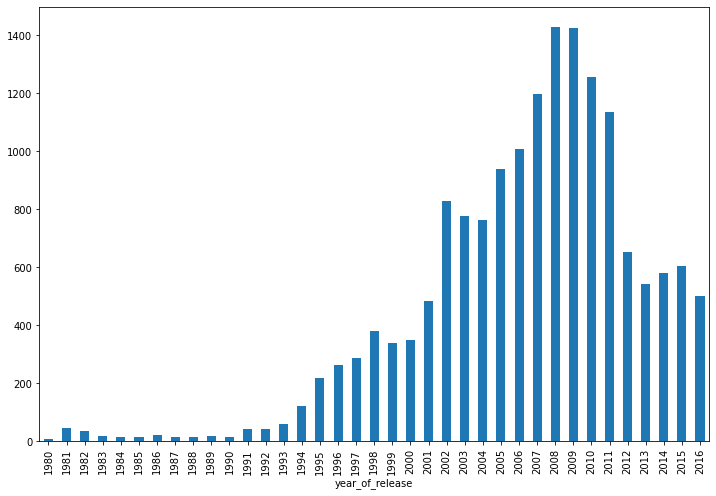

In [21]:
data.groupby('year_of_release')['name'].count().plot(kind='bar', figsize=(12,8))
plt.show()

Из данной диаграммы можем сделать первые выводы — в период с 2006 по 2011 выпускалось больше 1000 игр в год. А в 80е-90е годы игр выходило мало, но этот временной период не интересует нас в дальнейшем исследовании. \
Но данный график не отражает, как продавались игры на разных платформах. Перейдём к более детальному анализу.

#### Изучение продаж по платформам.

Посмотрим, как менялись продажи по платформам. Для начала, сформируем сводную таблицу по суммарным продажам каждой из платформ и на её основе построим столбчатую диаграмму:

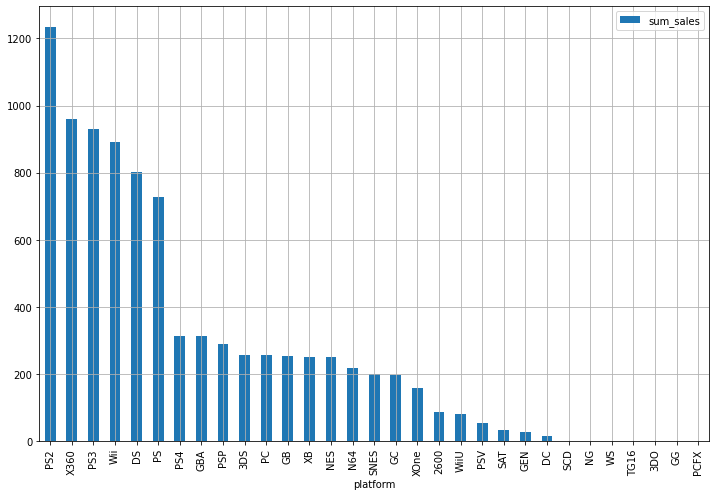

In [22]:
data_pivot_plat = (
    data
    .pivot_table(index = 'platform', values = 'sum_sales', aggfunc= 'sum')
    .sort_values(by='sum_sales', ascending=False)
    .plot(y='sum_sales', kind='bar', figsize=(12, 8), grid=True)
)
plt.show()

На этом графике наглядно видим платформы с наибольшими суммарными продажами (более 700), обратим своё внимание на них. Возьмём шесть наиболее популярных платформ (PS2, Xbox360, PS3, Wii, DS и PS) и построим распределение продаж по годам.

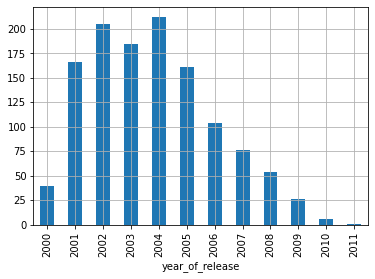

In [23]:
(
    data
    .query('platform == "PS2"')
    .groupby('year_of_release')['sum_sales'].sum()
    .plot(y='sum_sales', kind='bar', grid=True)
)
plt.show()

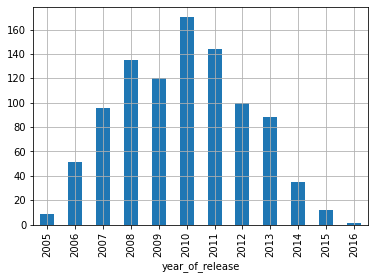

In [24]:
(
    data
    .query('platform == "X360"')
    .groupby('year_of_release')['sum_sales'].sum()
    .plot(y='sum_sales', kind='bar', grid=True)
)
plt.show()

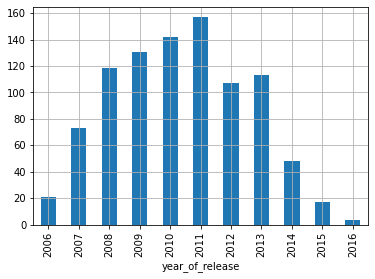

In [25]:
(
    data
    .query('platform == "PS3"')
    .groupby('year_of_release')['sum_sales'].sum()
    .plot(y='sum_sales', kind='bar', grid=True)
)
plt.show()

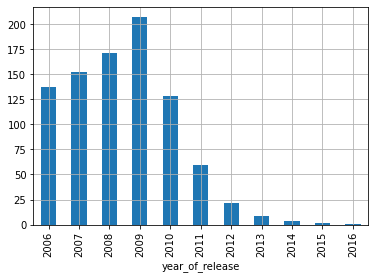

In [26]:
(
    data
    .query('platform == "Wii"')
    .groupby('year_of_release')['sum_sales'].sum()
    .plot(y='sum_sales', kind='bar', grid=True)
)
plt.show()

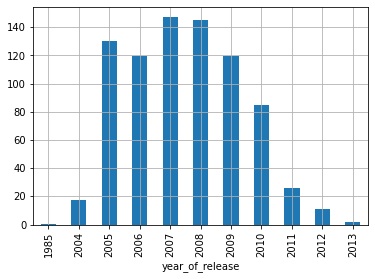

In [27]:
(
    data
    .query('platform == "DS"')
    .groupby('year_of_release')['sum_sales'].sum()
    .plot(y='sum_sales', kind='bar', grid=True)
)
plt.show()

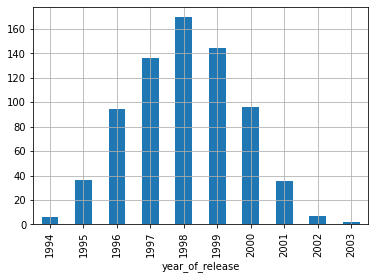

In [28]:
(
    data
    .query('platform == "PS"')
    .groupby('year_of_release')['sum_sales'].sum()
    .plot(y='sum_sales', kind='bar', grid=True)
)
plt.show()

Видим, что обычно "срок жизни" современных платформ составляет 5 лет, после чего продажи идут вниз. Тогда, возьмём данные за последние 5 лет от текущего 2016 года и исследуем их продажи и тенденции роста и падения:

#### Изучение потенциально прибыльных платформ.

Для удобства дальнейшего анализа выделим данные за актуальный период в отдельную переменную:

In [29]:
data_fresh = data.query('year_of_release >= 2012')

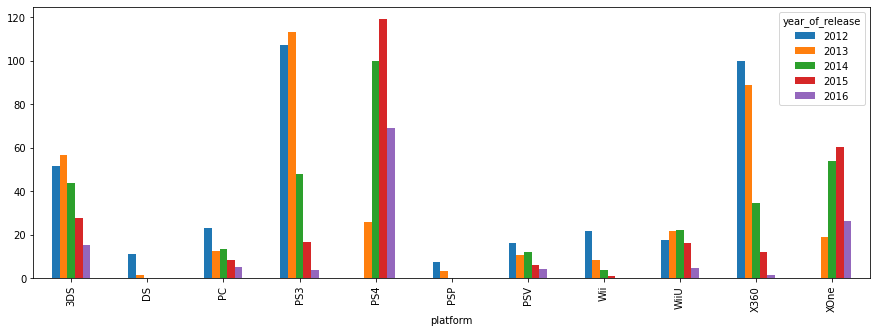

In [30]:
actual_period = data_fresh.pivot_table(
    index='platform', columns='year_of_release', values='sum_sales', aggfunc='sum')
actual_period.plot(kind='bar', figsize=(15,5))
plt.show()

Исходя из представленных диаграмм и учитывая возможную неполноту данных за 2016 год, можем заметить, что продажи только на двух платформах — PS4 и Xbox One постепенно растут, а значит можно предположить, что именно эти платформы можно считать потенциально прибыльными.

Для наглядности построим боксплот и воспользуемся методом .describe():

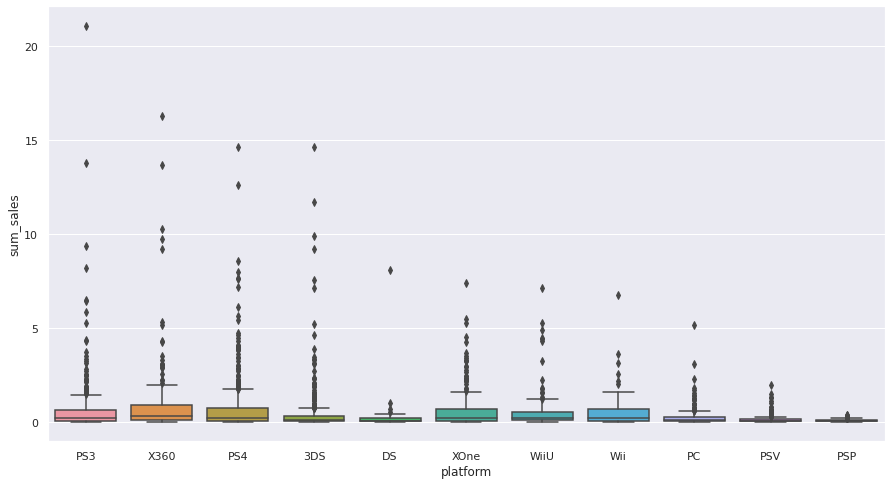

In [31]:
sns.set(rc={'figure.figsize':(15,8)})
sns.boxplot(data=data_fresh, x='platform', y='sum_sales')
plt.show()

И масштабируем его:

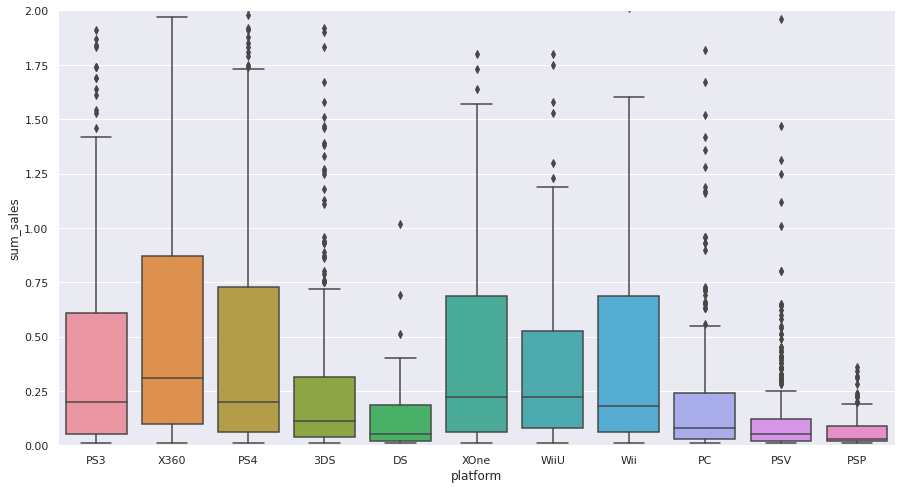

In [32]:
sns.set(rc={'figure.figsize':(15,8)})
sns.boxplot(data=data_fresh, x='platform', y='sum_sales')
plt.ylim([0,2])
plt.show()

In [33]:
data_fresh.query('platform == "PS4"')['sum_sales'].describe()

count   392.00
mean      0.80
std       1.61
min       0.01
25%       0.06
50%       0.20
75%       0.73
max      14.63
Name: sum_sales, dtype: float64

In [34]:
data_fresh.query('platform == "XOne"')['sum_sales'].describe()

count   247.00
mean      0.65
std       1.04
min       0.01
25%       0.06
50%       0.22
75%       0.69
max       7.39
Name: sum_sales, dtype: float64

In [35]:
Q1 = data_fresh.query('platform == "PS4"')['sum_sales'].quantile(q=.25)
Q3 = data_fresh.query('platform == "PS4"')['sum_sales'].quantile(q=.75)
print('Граница выбросов продаж на PS4:', '{:.3f}'.format((Q3-Q1)*1.5+Q3), 'млн копий') 
#ищем IQR и вычисляем границу выбросов по формуле

Граница выбросов продаж на PS4: 1.735 млн копий


In [36]:
Q1 = data_fresh.query('platform == "XOne"')['sum_sales'].quantile(q=.25)
Q3 = data_fresh.query('platform == "XOne"')['sum_sales'].quantile(q=.75)
print('Граница выбросов продаж на XOne:', '{:.3f}'.format((Q3-Q1)*1.5+Q3), 'млн копий')
#ищем IQR и вычисляем границу выбросов по формуле

Граница выбросов продаж на XOne: 1.623 млн копий


Исходя из рассчитанных данных, получаем очень схожую картину по продажам на PS4 и Xbox One:
* Медианное значение продаж игры составляет 200 тыс. и 220 тыс. копий соответственно.
* В среднем игра продаётся тиражом 800 тыс. и 650 тыс. копий соответственно.
* Границы выбросов на представленном графике также схожи и составляют около 1,7 млн. на PS4 и около 1,6 млн. на Xbox One, это означает, что продажи выше этих чисел будут крайне редкими.

#### Изучение связи между отзывами и продажами.

Рассмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. В первую очередь отсортируем платформы из актуального датасета по популярности:

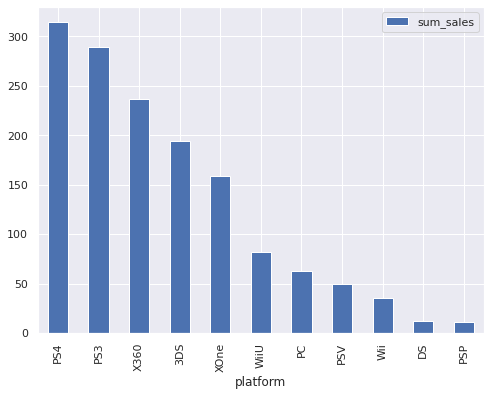

In [37]:
data_pivot_fresh = data_fresh.pivot_table(index = 'platform', values = 'sum_sales', aggfunc= 'sum').sort_values(by='sum_sales', ascending=False)
    
data_pivot_fresh.plot(y='sum_sales', kind='bar', figsize=(8, 6), grid=True)
plt.show()

В качестве примера возьмём PS4 как самую популярную платформу за последние 5 лет. Для удобства анализа вынесем данные по ней в отдельную переменную, не забыв отсеять заглушки:

In [38]:
data_ps4_critics = data_fresh.query('platform == "PS4" and critic_score != 160')
data_ps4_users = data_fresh.query('platform == "PS4" and user_score != 16')

Построим диаграммы рассеяния и посчитаем коэффициент корреляции Пирсона:

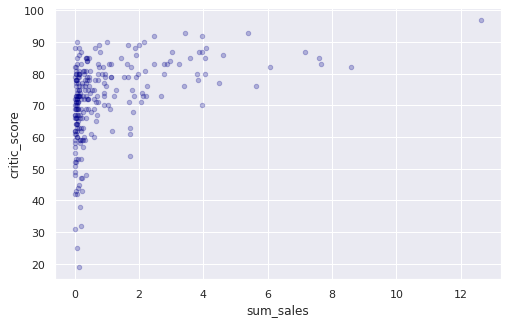

Коэффициент корреляции Пирсона: 0.407


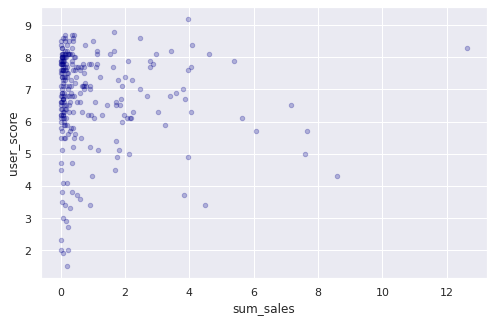

Коэффициент корреляции Пирсона: -0.032


In [40]:
(
    data_ps4_critics
    .plot(x='sum_sales', y='critic_score', kind='scatter', color="DarkBlue", alpha=0.25, figsize=(8,5))
) 
plt.show()
print('Коэффициент корреляции Пирсона:','{:.3f}'.format(data_ps4_critics['sum_sales'].corr(data_ps4_critics['critic_score'])))
(
    data_ps4_users
    .plot(x='sum_sales', y='user_score', kind='scatter', color="DarkBlue", alpha=0.25, figsize=(8,5))
) 
plt.show()
print('Коэффициент корреляции Пирсона:','{:.3f}'.format(data_ps4_users['sum_sales'].corr(data_ps4_users['user_score'])))

Судя по данным графикам и рассчитанным коэффициентам корреляции, связь между итоговыми продажами игры и её оценкой у критиков хоть и существует, но является слабой, а связи между продажами игры и её оценкой у пользователей нет, т.к. коэффициент корреляции около нуля, а значит эти два параметра никак не связаны между собой.

Теперь исследуем связь между продажами и оценками, основываясь на данных по другим популярным платформам:

В качестве предмета исследования возьмём топ-5 популярных платформ за актуальный период, который мы определили выше.

In [41]:
data_pivot_fresh.head(5)

,sum_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32


Сходным образом построим диаграммы рассеяния и посчитаем коэффициент корреляции Пирсона для оставшихся четырех платформ:

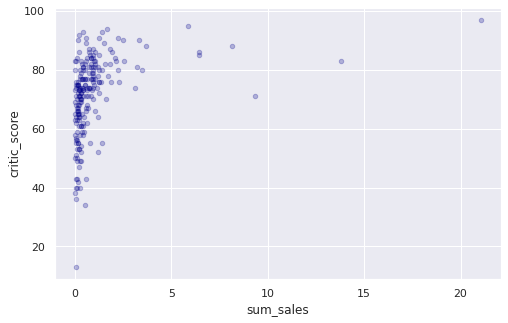

Коэффициент корреляции Пирсона: 0.331


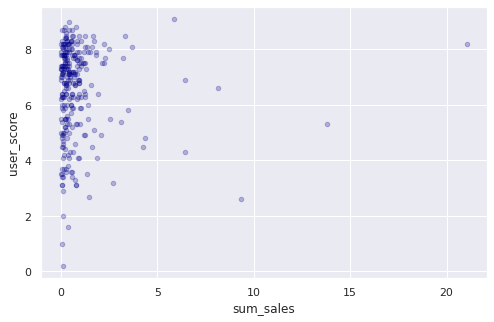

Коэффициент корреляции Пирсона: -0.005


In [42]:
data_ps3_critics = data_fresh.query('platform == "PS3" and critic_score != 160')
data_ps3_users = data_fresh.query('platform == "PS3" and user_score != 16')
(
    data_ps3_critics
    .plot(x='sum_sales', y='critic_score', kind='scatter', color="DarkBlue", alpha=0.25, figsize=(8,5))
) 
plt.show()
print('Коэффициент корреляции Пирсона:','{:.3f}'.format(data_ps3_critics['sum_sales'].corr(data_ps3_critics['critic_score'])))
(
    data_ps3_users
    .plot(x='sum_sales', y='user_score', kind='scatter', color="DarkBlue", alpha=0.25, figsize=(8,5))
) 
plt.show()
print('Коэффициент корреляции Пирсона:','{:.3f}'.format(data_ps3_users['sum_sales'].corr(data_ps3_users['user_score'])))

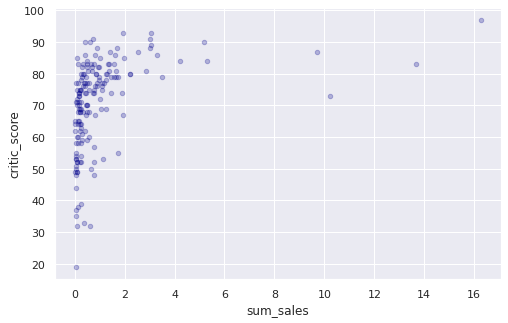

Коэффициент корреляции Пирсона: 0.361


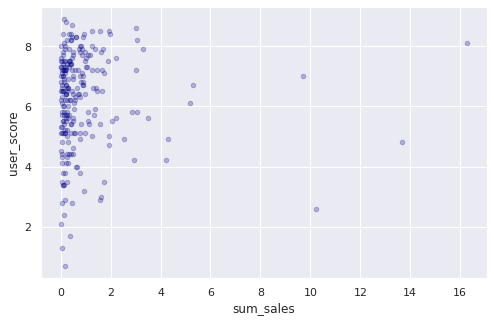

Коэффициент корреляции Пирсона: 0.006


In [43]:
data_x360_critics = data_fresh.query('platform == "X360" and critic_score != 160')
data_x360_users = data_fresh.query('platform == "X360" and user_score != 16')
(
    data_x360_critics
    .plot(x='sum_sales', y='critic_score', kind='scatter', color="DarkBlue", alpha=0.25, figsize=(8,5))
) 
plt.show()
print('Коэффициент корреляции Пирсона:','{:.3f}'.format(data_x360_critics['sum_sales'].corr(data_x360_critics['critic_score'])))
(
    data_x360_users
    .plot(x='sum_sales', y='user_score', kind='scatter', color="DarkBlue", alpha=0.25, figsize=(8,5))
) 
plt.show()
print('Коэффициент корреляции Пирсона:','{:.3f}'.format(data_x360_users['sum_sales'].corr(data_x360_users['user_score'])))

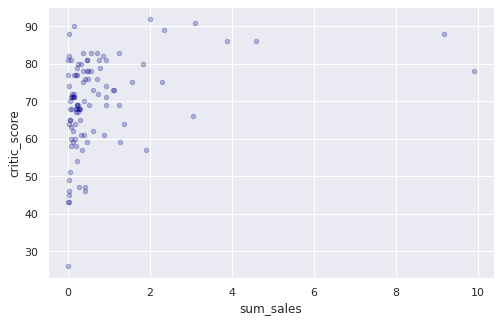

Коэффициент корреляции Пирсона: 0.321


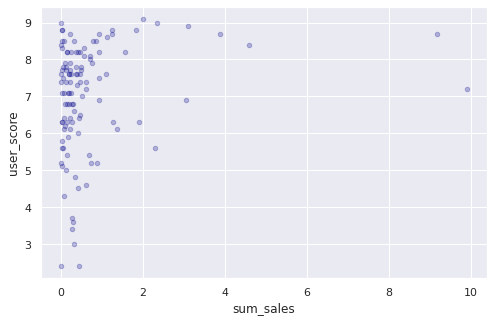

Коэффициент корреляции Пирсона: 0.198


In [44]:
data_3ds_critics = data_fresh.query('platform == "3DS" and critic_score != 160')
data_3ds_users = data_fresh.query('platform == "3DS" and user_score != 16')
(
    data_3ds_critics
    .plot(x='sum_sales', y='critic_score', kind='scatter', color="DarkBlue", alpha=0.25, figsize=(8,5))
) 
plt.show()
print('Коэффициент корреляции Пирсона:','{:.3f}'.format(data_3ds_critics['sum_sales'].corr(data_3ds_critics['critic_score'])))
(
    data_3ds_users
    .plot(x='sum_sales', y='user_score', kind='scatter', color="DarkBlue", alpha=0.25, figsize=(8,5))
) 
plt.show()
print('Коэффициент корреляции Пирсона:','{:.3f}'.format(data_3ds_users['sum_sales'].corr(data_3ds_users['user_score'])))

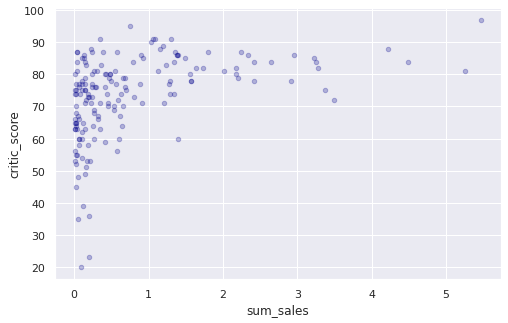

Коэффициент корреляции Пирсона: 0.417


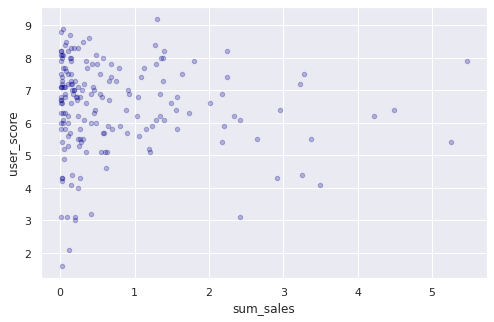

Коэффициент корреляции Пирсона: -0.069


In [45]:
data_xone_critics = data_fresh.query('platform == "XOne" and critic_score != 160')
data_xone_users = data_fresh.query('platform == "XOne" and user_score != 16')
(
    data_xone_critics
    .plot(x='sum_sales', y='critic_score', kind='scatter', color="DarkBlue", alpha=0.25, figsize=(8,5))
) 
plt.show()
print('Коэффициент корреляции Пирсона:','{:.3f}'.format(data_xone_critics['sum_sales'].corr(data_xone_critics['critic_score'])))
(
    data_xone_users
    .plot(x='sum_sales', y='user_score', kind='scatter', color="DarkBlue", alpha=0.25, figsize=(8,5))
) 
plt.show()
print('Коэффициент корреляции Пирсона:','{:.3f}'.format(data_xone_users['sum_sales'].corr(data_xone_users['user_score'])))

На основе построенных диаграмм и рассчитанных коэффициентов корреляции для каждой из платформ можем сделать вывод, что во всех случаях связь оценок критиков с продажами игр является слабой (коэф. 0,3-0,4). \
Как и в случае с PS4, на других платформах нет какой-либо закономерности между оценками пользователей и успешностью игры на рынке, за исключением Nintendo 3DS, однако и в её случае взаимосвязь является очень слабой и неочевидной.

#### Распределение продаж по жанрам.

Обратимся к распределению игр по жанрам, для этого построим боксплот:

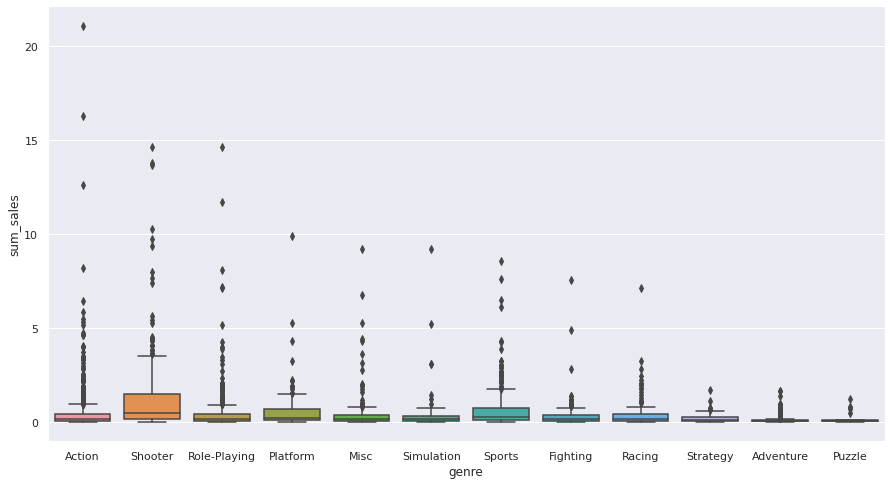

In [46]:
sns.set(rc={'figure.figsize':(15,8)})
sns.boxplot(data=data_fresh, x='genre', y='sum_sales')
plt.show()

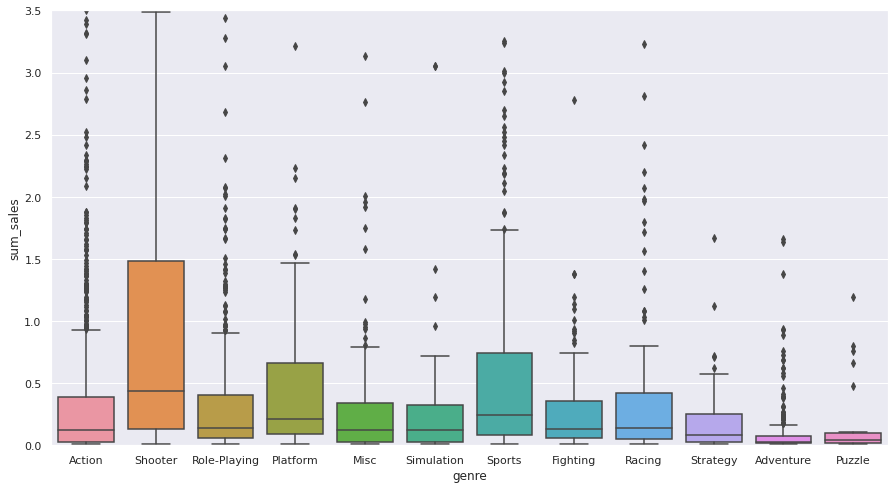

In [47]:
sns.set(rc={'figure.figsize':(15,8)})
sns.boxplot(data=data_fresh, x='genre', y='sum_sales')
plt.ylim([0,3.5])
plt.show()

In [48]:
data_topgenres_pivot = data_fresh.pivot_table(index = 'genre', values = 'sum_sales', aggfunc= 'median').sort_values(by='sum_sales', ascending=False)
data_topgenres_pivot.rename(columns = {'genre' : 'First Name', 'sum_sales' : 'median_sales'}, inplace = True)
data_topgenres_pivot

,median_sales
genre,
Shooter,0.44
Sports,0.24
Platform,0.21
Role-Playing,0.14
Racing,0.14
Fighting,0.13
Action,0.12
Misc,0.12
Simulation,0.12


Медианные продажи жанра "шутер" являются самыми высокими — 440 тыс. проданных копий, затем идут "спорт" (240 тыс.) и "платформер" (210 тыс.). Жанры "пазл" и "приключения" продавались хуже всего — 40 тыс. и 30 тыс. медианных продаж соответственно.

#### Вывод:

На основе исследовательского анализа можем сделать следующие промежуточные выводы:
* Средний "срок жизни" современных платформ составляет 5 лет, после чего продажи идут вниз.
* Продажи на PS4 и Xbox One за актуальный период постепенно расли, а значит можно предположить, что именно эти платформы можно считать потенциально прибыльными. 
* В среднем игра продаётся тиражом 800 тыс. и 650 тыс. копий соответственно. Продажи одной игры выше 1,7 млн. на PS4 и 1,6 млн. на Xbox One будут крайне редкими.
* Во всех описанных нами случаях связь оценок критиков с продажами игр является слабой (коэф. 0,3-0,4), также нет какой-либо закономерности между оценками пользователей и успешностью игры на рынке, за исключением Nintendo 3DS, где данная связь представлена слабо.
* Самыми продаваемыми жанром является "шутер" —  медианная продажа составляет 440 тыс. проданных копий, а "пазл" и "приключения" продавались хуже всего — 40 тыс. и 30 тыс. медианных продаж соответственно.

### Составление портрета пользователя по каждому из регионов

#### Популярность платформ в регионах.

Для составления портрета пользователя сформируем сводные таблицы по платформам и жанрам для каждого региона:

In [49]:
data_region_sales = data_fresh.pivot_table(index = 'platform',  values = ['na_sales','jp_sales','eu_sales'], aggfunc = 'sum')
data_region_genres = data_fresh.pivot_table(index = 'genre',  values = ['na_sales','jp_sales','eu_sales'], aggfunc = 'sum')

Рассмотрим самые популярные платформы и жанры в каждом из регионов. Для наглядности построим круговые диаграммы:

In [50]:
data_eu_sales = data_region_sales['eu_sales'].sort_values(ascending=False).head(5) #для построения графика
data_na_sales = data_region_sales['na_sales'].sort_values(ascending=False).head(5) #сформируем сводные таблицы по популярным
data_jp_sales = data_region_sales['jp_sales'].sort_values(ascending=False).head(5) #платформам в каждом регионе

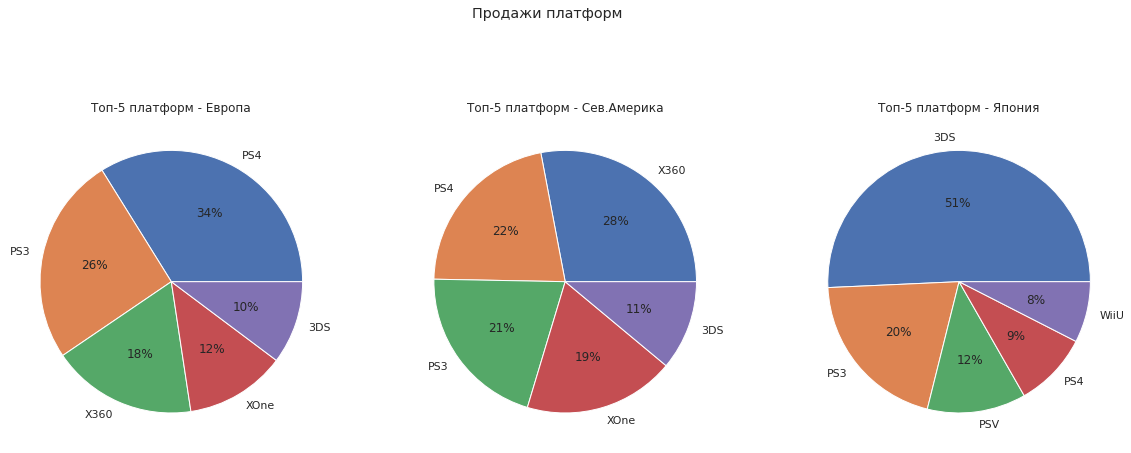

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
fig.suptitle('Продажи платформ')
ax1.pie(data_eu_sales, labels=data_eu_sales.index, autopct='%1.0f%%')
ax1.set_title('Топ-5 платформ - Европа')
ax2.pie(data_na_sales, labels=data_na_sales.index, autopct='%1.0f%%')
ax2.set_title('Топ-5 платформ - Сев.Америка')
ax3.pie(data_jp_sales, labels=data_jp_sales.index, autopct='%1.0f%%')
ax3.set_title('Топ-5 платформ - Япония')
plt.show()

* Видим, что в Европе лидерами по продажам являются Playstation 3 и 4 — 26% и 34% соответственно. 
* В Северной Америке более высокая плотность результатов — обе Playstation и Xbox One занимают долю от 19 до 22 процентов, а на первом месте до сих пор Xbox360 — 28%. 
* В обоих регионах относительно невысока популярность Nintendo 3DS — около 10%, тогда как в Японии, наоборот, эта консоль занимает свыше 50% рынка. 
* PS3, вторая по популярности платформа в Японии имеет долю 20%, сходную с долей этой консоли в Сев.Америке.
* Продукция компании Microsoft вообще не представлена в топ-5 платформах на японском рынке.

#### Популярность жанров в регионах.

Аналогичным образом подготовим сводные таблицы и построим круговые диаграммы для отображения популярности жанров по каждому из регионов:

In [52]:
data_eu_genres = data_region_genres['eu_sales'].sort_values(ascending=False).head(5) #для построения графика
data_na_genres = data_region_genres['na_sales'].sort_values(ascending=False).head(5) #сформируем сводные таблицы по популярным
data_jp_genres = data_region_genres['jp_sales'].sort_values(ascending=False).head(5) #платформам в каждом регионе

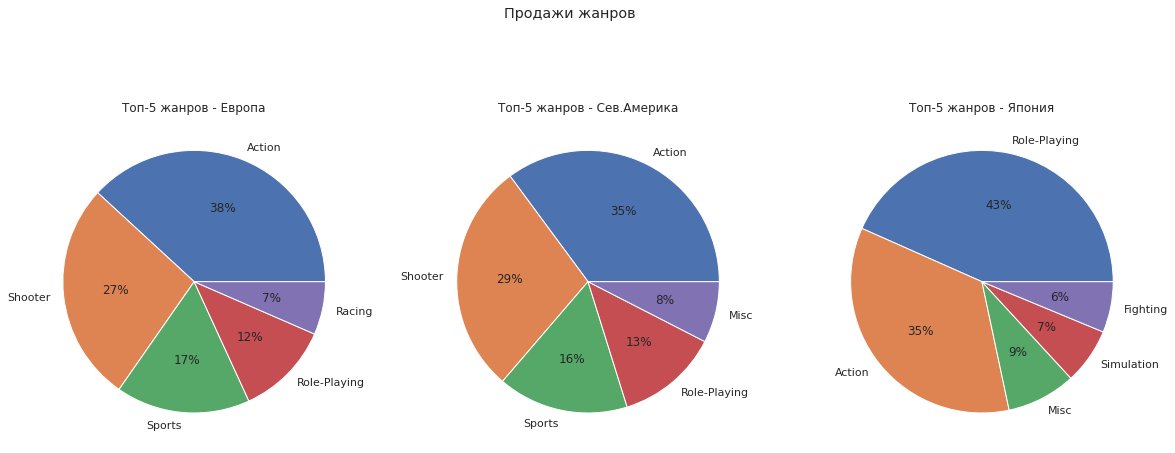

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
fig.suptitle('Продажи жанров')
ax1.pie(data_eu_genres, labels=data_eu_genres.index, autopct='%1.0f%%')
ax1.set_title('Топ-5 жанров - Европа')
ax2.pie(data_na_genres, labels=data_na_genres.index, autopct='%1.0f%%')
ax2.set_title('Топ-5 жанров - Сев.Америка')
ax3.pie(data_jp_genres, labels=data_jp_genres.index, autopct='%1.0f%%')
ax3.set_title('Топ-5 жанров - Япония')
plt.show()

* Доли самых популярных жанров в Америке и Европе во многом похожи друг на друга — первые четыре места ("экшн", "шутер", "спорт" и "РПГ") абсолютно идентичны и различаются лишь на несколько процентов. Самый продаваемый жанр — "экшн", имеет долю в 35% и 38% соотвественно.
* В Японии "экшн" также очень популярен и занимает 35% рынка, но самым популярным жанром является "РПГ" — 43%.
* На западе жанр "РПГ" менее популярен, чем в Японии и занимает долю 12-13%.

#### Влияние рейтинга ESRB на продажи.

Для начала разберёмся, какие обозначения рейтинга ESRB встречаются нам в актуальной таблице:

In [54]:
data_fresh['rating'].unique()

array(['M', 'Unknown', 'E', 'E10+', 'T'], dtype=object)

И для удобства интерпретации данных создадим функцию, которая возвращала бы рекомендуемый возраст пользователя для условных обозначений данного рейтинга:

In [55]:
def categorize_rating(rating):
    if rating['rating'] == 'E':
        return '3+'
    elif rating['rating'] == 'E10+':
        return '10+'
    elif rating['rating'] == 'T':
        return '13+'
    elif rating['rating'] == 'M':
        return '17+'
    else:
        return 'unknown'
data_fresh['rating_age'] = data_fresh.apply(categorize_rating, axis=1)

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Когда у нас выскакивают предупреждения, это означает, что в будущей новой версии библиотеки применяемый метод обработки будет не применим. Если мы планируем данный код использовать в будущем, то надо разобраться и изменить код. Если нам он в будущем не понадобится, то можно принудительно запретить вывод предупреждений вставив в ячейку с библиотеками вот такой код: <br>`pd.set_option('chained_assignment', None)` или такой: <br></font>
`import warnings`<br>
`warnings.filterwarnings("ignore")`

Наконец, построим сводную таблицу по продажам игр с различным возрастным рейтингом для разных регионов:

In [56]:
data_region_esrb = data_fresh.pivot_table(index = 'rating_age',  values = ['na_sales','jp_sales','eu_sales'], aggfunc = 'sum')

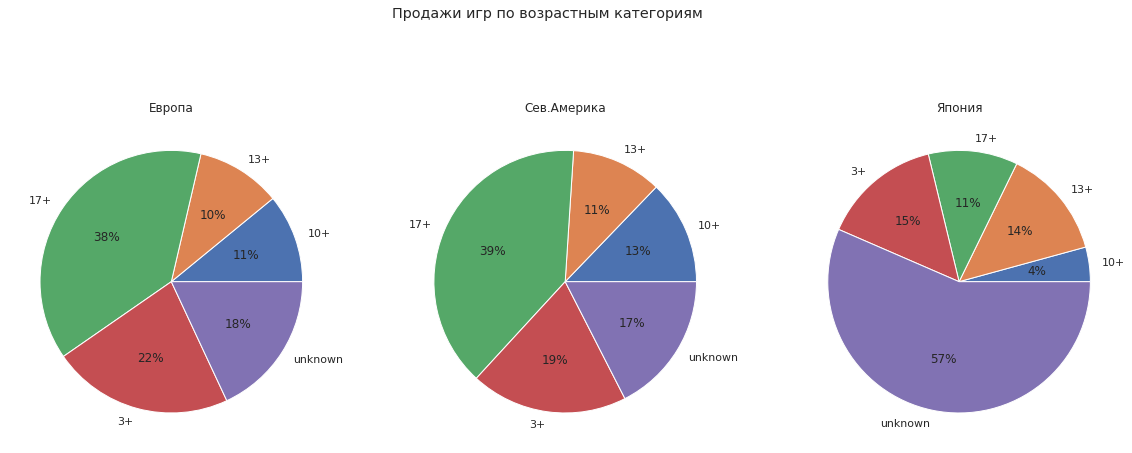

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
fig.suptitle('Продажи игр по возрастным категориям')
ax1.pie(data_region_esrb['eu_sales'], labels=data_region_esrb.index, autopct='%1.0f%%')
ax1.set_title('Европа')
ax2.pie(data_region_esrb['na_sales'], labels=data_region_esrb.index, autopct='%1.0f%%')
ax2.set_title('Сев.Америка')
ax3.pie(data_region_esrb['jp_sales'], labels=data_region_esrb.index, autopct='%1.0f%%')
ax3.set_title('Япония')
plt.show()

Как видим, продажи игр с рейтингом М (17+) в Европе и Северной Америке очень высоки, почти 40% всех игр. \
В то же время, в Японии картина совершенно иная: рейтинг ESRB предназначен для маркировки игр для США и Канады, а на территории Японии действует свой возрастной рейтинг CERO. Поэтому 57% игр, изданных в Японии, не получают возрастной оценки ESRB.

Также дополнительно можно взглянуть на хиты продаж, самые продаваемые игры и франшизы за актуальный период по каждому из регионов:

In [58]:
data_topgames_eu = data_fresh.pivot_table(index = 'name', values = 'eu_sales', aggfunc= 'sum').sort_values(by='eu_sales', ascending=False).head(6)
data_topgames_eu

,eu_sales
name,
Grand Theft Auto V,23.42
FIFA 15,12.02
FIFA 16,11.09
FIFA 14,10.96
Call of Duty: Black Ops II,10.84
FIFA Soccer 13,10.16


In [59]:
data_topgames_na = data_fresh.pivot_table(index = 'name', values = 'na_sales', aggfunc= 'sum').sort_values(by='na_sales', ascending=False).head(6)
data_topgames_na

,na_sales
name,
Grand Theft Auto V,23.84
Call of Duty: Ghosts,14.94
Call of Duty: Black Ops II,14.08
Call of Duty: Black Ops 3,12.25
Minecraft,11.28
Call of Duty: Advanced Warfare,10.51


In [60]:
data_topgames_jp = data_fresh.pivot_table(index = 'name', values = 'jp_sales', aggfunc= 'sum').sort_values(by='jp_sales', ascending=False).head(5)
data_topgames_jp

,jp_sales
name,
Animal Crossing: New Leaf,4.39
Pokemon X/Pokemon Y,4.35
Monster Hunter 4,3.44
Super Smash Bros. for Wii U and 3DS,3.24
Yokai Watch 2 Ganso/Honke,3.18


Как мы видим, GTA V является абсолютным лидером в Европе и Америке, суммарно более 47 млн проданных копий за последние 5 лет. Серии спортивных симуляторов FIFA и шутеров Call of Duty также выделяются своими продажами: свежие части этих франшиз продаются тиражами от 10 до 15 млн копий.

#### Вывод.

* Разные платформы и жанры популярны в разных регионах по-разному. 
* Некоторой стабильностью отличается Playstation 3 — доля 26%, 23% и 20% в Европе, Америке и Японии соответственно.
* Лидер по продажам в Европе — Playstation 4 (34%), в Америке — Xbox360 (28%). В Японии абсолютным лидером является 3DS —  свыше 50% рынка.
* Стабильно продающийся жанр — "экшн", имеет долю в 35-38% по всем регионам.
* В Японии самым популярным жанром является "РПГ" — 43%.
* Также на западе популярны "шутеры" — доля рынка 27-29%.
* GTA V является абсолютным лидером в Европе и Америке, суммарно более 47 млн проданных копий за последние 5 лет.
* Рейтинг ESRB не является помехой для продаж в Европе и Сев.Америке, рейтинг 17+ имеет почти 40% всех проданных игр. Но в Японии действует свой возрастной рейтинг CERO. Поэтому 57% игр, изданных в Японии, не получают возрастной оценки ESRB.

### Проверка гипотез

#### Проверим гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

В качестве нулевой гипотезы сформулируем следующее утверждение: \
Пользовательские рейтинги игр на платформе Xbox One = Пользовательские рейтинги игр на платформе PC \
Тогда альтернативной гипотезой будет: \
Пользовательские рейтинги игр на платформе Xbox One ≠ Пользовательские рейтинги игр на платформе PC

Применим t-test в качестве критерия проверки данной гипотезы. Его применение обуславливается тем, что генеральные совокупности не зависят друг от друга.

In [61]:
results = st.ttest_ind(data_fresh.query('platform == "XOne" and user_score != 16')['user_score'], data_fresh.query('platform == "PC" and user_score != 16')['user_score'], equal_var=False) # results = вызов метода для проверки гипотезы

alpha = 0.01 # задаём значение уровня значимости

print('p-значение:', results.pvalue)# вывод значения p-value на экран 

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Таким образом, вероятность получить такое или большее различие между генеральными совокупностями больше 50% — это слишком большая вероятность, чтобы делать вывод о большом различии между средними рейтингами на этих двух платформах.

#### Теперь проверим следующую гипотезу: Средние пользовательские рейтинги жанров Action и Sports разные.

В качестве нулевой гипотезы сформулируем следующее утверждение: \
Пользовательские рейтинги игр жанра Action = Пользовательские рейтинги игр жанра Sports \
Тогда альтернативной гипотезой будет: \
Пользовательские рейтинги игр жанра Action ≠ Пользовательские рейтинги игр жанра Sports

Аналогично применим t-test в качестве критерия проверки данной гипотезы. Генеральные совокупности не зависят друг от друга.

In [62]:
results = st.ttest_ind(data_fresh.query('genre == "Action" and user_score != 16')['user_score'], data_fresh.query('genre == "Sports" and user_score != 16')['user_score'], equal_var=False) # results = вызов метода для проверки гипотезы

alpha = 0.05 # задаём значение уровня значимости

print('p-значение:', results.pvalue)# вывод значения p-value на экран 

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


Таким образом, мы убедились в том, что средние пользовательские рейтинги жанров Action и Sports разные.

### Общий вывод.

В данном исследовании мы постарались выявить закономерности, влияющие на успешность продаж игры. 
* Выявить сильную связь между отзывами и продажами нам не удалось.
* Самыми прибыльными жанрами являются: "экшн", имеет долю в 35-38% по всем регионам; в Японии самым популярным жанром является "РПГ" — 43%. Также на западе популярны "шутеры" — доля рынка 27-29%.
* Самыми прибыльными консолями являются: в Европе — Playstation 4 (34%), в Америке — Xbox360 (28%). В Японии абсолютным лидером является 3DS — свыше 50% рынка.
* Самыми перспективными платформами можно назвать Playstation 4 и Xbox One, т.к. их продажи год от года растут.
* Рейтинг ESRB почти не влияет на продажи игр.
* Среди самых продаваемых франшиз на западном рынке — GTA (47 млн копий за пятилетний период), FIFA, Call of Duty (от 10 до 15 млн проданных копий), на эти игры можно сделать ставку в будущее время как потенциально продаваемые.
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
* Средние пользовательские рейтинги жанров Action и Sports разные.